# Semi-Supervised Anomaly Detection Survey
- source : https://www.kaggle.com/matheusfacure/semi-supervised-anomaly-detection-survey

In [35]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

We explore here some anomaly detection techniques, providing some simple intuition about how they work and what are their main advantages and disadvantages. This work is loosely bases on a [survey produced by Chandola et al `(`2009`)`](https://www.vs.inf.ethz.ch/edu/HS2011/CPS/papers/chandola09_anomaly-detection-survey.pdf), but it does not intend to cover all the techniques approached in their studies. We will begin describing what is an anomaly and what are its types, following with the challenges imposed by the mains characteristics of the anomaly detection problem.
Then, we will describe the nature of the dataset used in this work.

Although the dataset here considerer is specific to one kind of anomaly detection application, namely, fraud detection, we will treat it as if it was more general, not limiting ourself to the techniques recommended for the dataset we have. Our intention is to provide a practical survey of how some of the main anomaly detection techniques could be implemented, even if they are not tailored for fraud detection. Nonetheless, we will discuss when some method should be preferred, and in the process, justify why some methods yield better results than other in our particular case.

## What is an anomaly
"Anomalies are patterns in data that do not conform to a well defined notion of normal behavior" `(`Chandola et al, 2009`)`. In other words, we can think of them as data coming from another generating process than the one most observations came from. For example, in the image bellow, taken from the survey, we can see the points \( o_1 \) and \(o_2 \) `(`the \( O \) is for outliers`)` isolated from the others. This is a very strong cue that they are anomalies in this two dimensional 

![Image](https://www.researchgate.net/profile/Vipin_Kumar26/publication/220565847/figure/fig1/AS:340388092104705@1458166253261/Fig-1-A-simple-example-of-anomalies-in-a-2-dimensional-data-set.png)

Moreover, points in region \( O_3 \) are also anomalies. Even though they fall in a neighborhood of data, all points in that neighborhood are also anomalies, thus coming from another distribution than those marked with \( N_1 \) and \( N_2 \), where the normal data lies. Anomalies may arise for many reasons. Some examples are credit card frauds, malfunctioning machines or sensors, government corruption, economic crises or sintoms from diseases.

There are three types of anomalies. The first one is point anomaly, that is, "an individual data instance can be considered as anomalous with respect to the rest of data" `(`idem`)`. In the image above, instance \( o_1 \) and \( o_2 \) and all instances in \( O_3 \) are point anomalies since they lie outside the normal regions. As another example, consider credit card transaction data, with information only about amount spent. Then, a transaction to hight compared to the rest for a particular individual is an anomaly.

The second type of anomaly is contextual. In this case, the data must have features regarding some contextual attribute `(`e.g. time, space`)` and some features regarding behavioral attributes. The anomaly is than determined withing a given context. As an example, consider again credit card transactions, but now we have both information about the amount spend and day of the year. Now, a hight amount transaction might be considered normal if it occurred in the week before Christmas, but the same amount transaction in July might be suspicious. We could also have information about the location the client is when performing transactions, and than expect hight amounts if we detect he/she is somewhere far from home, as in a vacation.

The final type of anomaly is collective. In this case, some related data instances are anomalous with respect to the entire data set, but each individual instances may not be considered anomalous. As an example, consider the stock of a retailer. We expect to see its volume fluctuating in time, with low values followed by hight values. However, a low stock for a long period of time is a anomaly. Note that the low volume per se is not an anomaly, but it persistence is. 

Note that the last two types assume some relation among data instances, that is, they are not independent identically distributed `(`i.i.d`)`. In the present work, we have credit card transaction information and time is one of the features, so we could treat this problem as contextual anomaly detection. However, we only have tow days of data, making int almost impossible to determine a useful temporal context. Hence, we will only consider point anomalies techniques to avoid the burden in the extra work of defining a context. Nonetheless, we will keep time as a feature, so in some sense the contextual information will be considered, although no directly modeled.

One final consideration that we need to make is that here only semi-supervised approaches to machine learning will be considered. The other possibility would be to simply use supervised classification methods with some data processing. Since our purpose it to make a anomaly detection survey and not a machine learning clarification survey, we will ignore these techniques. Instead, we refer to the Kaggle website, where most notebooks within the data here consider uses classification supervised approaches for solving the anomaly detection problem. Fore those interesting in supervised anomaly detection,  we recommend a particularly good notebook made by the user joparga3: [In depth skewed data classification](https://www.kaggle.com/joparga3/d/dalpozz/creditcardfraud/in-depth-skewed-data-classif-93-recall-acc-now). We will also use his results as a benchmark `(`and a little bit of his code`)`.

## Challenges

One straightforward approach to anomaly detection would be to simply define a region were the normal data lies and classify anything out of that region as an anomaly. This is most easily said than done and there are some major challenges that often arise in anomaly detection problem:

    - Modeling a normal region that captures all normal behavior is extremely difficult and the boundary between normal an abnormal is often blurred.
    
    - Anomalies might be the result of malicious actions. Than, the malicious adversaries are always trying to adapt to make anomalous observations seem normal.
    
    - The normal behavior can change, and then a current notion of normal might not be valid in the future.
    
    - As we've seen, the notion of an anomaly varies for different application domains, and there is no algorithm that can handle all of them equally well.
    
    - Labeled data for training/validation of models used by anomaly detection techniques is usually a major issue, being either extremely scarce or non existent.
    
    - If the data contains a lot of noise, it is difficult to distinguish noisy instances from anomalies.

In [36]:
import pandas as pd # for data analytics
import numpy as np # for numerical computation
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

#style.use('ggplot')
np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Dataset

We will use the “Credit Card Fraud Detection”. Following the description provided, "the datasets contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class `(`frauds`)` account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."

As said before, we will consider semi-supervised techiques, were we assume that the training data has labeled instances for only the normal class. In this case, we typically build a model to capture only the normal behavior, tune the model complexity in a labeled validation set and evaluate the model in a equally labeled testing set. More formally, during training, we only model \( P(x) \), that is, the probability of the normal data. At test time, we classify as an anomaly instances that have very low probability. Even when such probability is not directly available in the model, we can, most of the time define a score function proportional to it. Using a validation set, we can tune a threshold for the probability or score below which we will classify the instance as an anomaly. 

For more detailed explanation about the semi-supervised approach, please refer to Andrew Ng's [playlist about anomaly detection](https://www.youtube.com/playlist?list=PLnnr1O8OWc6b_KudrHI0Vcf6sEu6xs9Ky).

Since some of the techniques considered works `(`much`)` better if the features are all Gaussian, we will transform the `Amount` and `Time` features to make them more Gaussian like. Our approach will be to simply take the \( log \) transformation of them. Since some features have zeros, we first add one to \( log \) of zero. 


In [37]:
dataset = pd.read_csv('D:/2021_데이터솔루션/data/creditcard.csv')#.drop('Time', axis=1)

dataset['Amount'] = np.log(dataset['Amount'] + 1)
dataset['Time'] = np.log(dataset['Time'] + 1)
normal = dataset[dataset['Class'] == 0]

anomaly = dataset[dataset['Class'] == 1]
print(normal.shape)
print(anomaly.shape)

(284315, 31)
(492, 31)


To split the data, we will hold 50% of the **normal** instances for training. The rest of the normal data will be equally split among a validation and a test set. The abnormal instances will also be equally spitted between the validation and test set.

In [38]:
from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

Train shape:  (227452, 31)
Proportion os anomaly in training set: 0.00

Valid shape:  (28677, 31)
Proportion os anomaly in validation set: 0.01

Test shape:,  (28678, 31)
Proportion os anomaly in test set: 0.01



We can see that even after splitting the normal instances in two, the proportion of anomalies in the test and validation set are still very small.

## Evaluation Metrics
Since the data is heavily unbalanced, there is no point in using simple accuracy as evaluation metrics, since a naive model that always predicts a normal class would get more than 99% accuracy. We will thus use precision and recall metrics. As in Sklearn documentations:

"A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Precision ( \( P\) ) is defined as the number of true positives ( \( T_p\) ) over the number of true positives plus the number of false positives (\( F_p\)):

$$P = \frac{T_p}{T_p + F_p}$$

Recall (\( R \)) is defined as the number of true positives (\( T_p \)) over the number of true positives plus the number of false negatives (\( F_n \)):

$$R = \frac{T_p}{T_p + F_n}$$

These quantities are also related to the (\( F_1 \)) score."

Since we are in a scenario of credit card fraud detection, failing to detect a fraud has a higher cost than assigning as fraudulent a normal transaction. Hence, we are more concerned with a high recall metric, as this shows that our system can consistently detect frauds, even if this means getting a few false positives. Nonetheless, we don't want to have a lot of false positives, since there is also a cost in verifying to much transactions assigned as frauds. 

So we can summarize our model's performance in a single metric, we will use the `(`\( F_2 \)`)` score, which places more importance in recall than precision. Formally, it is defined as

$$F_2 = (1+2^2) \frac{P * R}{2^2 * P + R}$$

We will also report confusion matrix for a better understanding of how our errors are distributed.

## Benchmarks

As  a benchmark, we will use joparga3’s notebook. In one of his experiment. As in the time of this writing, the final result was 85284 true negatives, 91 true positives, 56 false negatives and 12 false positives. This results in the following metrics:

$$P = 0.883$$
$$R = 0.619$$
$$F_2 = 0.658$$

## Statistical Anomaly Detection Techniques

As cited in Chandola et al, "an anomaly is an observation which is suspected of being partially or wholly irrelevant because it is not generated by the stochastic model assumed” `(`Anscombe and Guttman 1960`)`. Hence, we assume that *Normal data instances occur in high probability regions of a stochastic model, while anomalies occur in the low probability regions of the stochastic model.* In the statistical model techniques we fit a statistical model and perform statistical inference to decide if an unseen observation comes from the model distribution or not. One advantage of this methods is that we can associate a confidence interval to each prediction, which can help when deciding on a course of action to deal with the anomalies. Another advantages is that if the model is robust to anomalies, it can be used in an unsupervised fashion, without needing any labeled data.

Here we will consider only two statistical anomaly detection techniques.

### Gaussian Model Based

In this technique, we assume that the data comes from a Gaussian distribution. We can fit such a Gaussian using simple *Maximum Likelihood Estimates* `(`MLE`)`. Then, the distance from the mean in standard deviations is the anomaly score for an data instance:

$$\pmb{z}=\frac{|\pmb{x}-\pmb{\bar{x}}|}{\pmb{s}}$$

Where \( \pmb{\bar{x}} \) is the sample mean and \( \pmb{s} \) is the sample variance. We can use a validation set to find an optimal threshold for the score, above which we will consider the instance an anomaly. This is equivalent to finding a hypersphere where the center is the sample mean and the radius is determined by the threshold. Data points outside this sphere will be classified as anomalous. One drawback of this technique is that it does not account for relationships among variables. More technically, this model assumes that that each feature in the data is linear independent from one another and that probabilities of the data can be decomposed as follows

$$P(\pmb{X})=P(\pmb{x_1})*P(\pmb{x_2})*...*P(\pmb{x_d})$$

This would not be a problem if all our variables where principal components extracted from PCA, since they would be linear independent, but as this is not the case, we better account for correlation among features. To do that, we simply use the use the Mahalanobis distance of a test instance \( \pmb{x} \) to the sample mean \( \pmb{\bar{x}} \). So that this score reflects a valid probability distribution, we will fit a full covariance matrix multi-variate normal distribution to the data:

$$\widehat{P(\pmb{x})}=\frac{1}{\sqrt{(2 \pi)^d * det \pmb{S}^{-1}}} * exp \Big(-\frac{1}{2}*(\pmb{x}-\pmb{\bar{x}})^T\pmb{S}^{-1}(\pmb{x}-\pmb{\bar{x}})\Big)$$

were \( \pmb{S} \) is the sample covariance matrix. This fix the problem of assuming linear independence. 

In [39]:
train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,11.888241,-0.643139,0.323888,-0.253890,-0.229861,-0.320347,-0.337035,0.016371,0.511599,0.664531,...,0.264600,0.641559,0.167731,0.639755,-0.782464,0.447755,-0.108167,0.041705,4.617296,0
1,10.651951,1.225032,0.309672,0.075764,1.172093,0.049135,-0.352607,0.201216,-0.067050,-0.178754,...,-0.006992,0.112232,-0.198475,0.012800,0.853472,-0.257058,0.005308,-0.000296,0.693147,0
2,11.211401,1.095432,-0.082201,0.557413,0.672936,-0.471535,-0.151216,-0.182268,0.145532,0.146361,...,-0.138794,-0.375464,0.083377,0.224129,0.211780,0.211859,-0.021616,0.005800,3.397858,0
3,11.645242,0.225211,-0.101200,0.597409,-1.261143,-0.482422,-0.508390,0.338604,-0.122385,-0.962887,...,-0.242758,-0.249014,0.263371,1.144209,-0.580231,0.423566,-0.010651,0.016041,4.158883,0
4,12.007896,-2.001444,-1.084340,0.042545,-1.061416,1.004215,2.054346,2.173900,0.347613,-0.991819,...,0.699938,1.070446,0.585468,-0.922432,1.156154,0.683653,-0.197059,0.055466,6.200509,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227447,11.234784,-1.438013,1.298178,0.909734,-0.495798,0.255640,-0.766527,0.449792,0.361424,-0.492433,...,-0.141175,-0.479615,0.105791,0.038759,-0.299486,-0.087374,-0.033205,0.108152,1.790091,0
227448,11.978011,0.256621,0.223809,0.975735,-0.220988,-0.270464,0.568080,-0.394989,-0.637367,0.416232,...,1.080174,0.763228,-0.220929,0.824970,0.789579,-0.064883,0.223809,0.257101,3.712352,0
227449,11.288456,-0.138855,-0.976921,0.883736,-3.393556,1.142488,3.914621,-1.119220,0.869570,-1.539373,...,-0.228985,-0.147826,-0.093426,0.977747,-0.269920,-0.413884,0.018587,-0.078387,3.044522,0
227450,11.387158,-0.422831,0.239428,1.512375,-1.075881,-0.809157,-0.089498,0.838381,-0.463100,-0.698558,...,-0.568205,-0.860065,-0.002557,-0.079295,-0.594139,-0.644110,-0.140223,-0.106076,4.826312,0


#### <font color='red'> 평균이 '0', 분산이 '1'인 분포의 함수를 model로 간주하고 '-3' ~ '3'까지 120개의 자료를 pdf(probability density function)함수(알고리즘)로 fitting
- <font color = 'red'> Start

(120,)

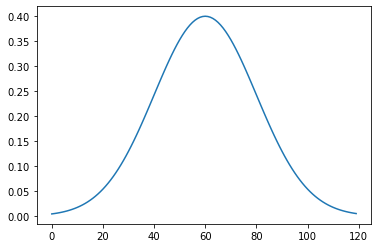

In [40]:
from scipy.stats import norm
model = norm(loc=0, scale=1)
xx = np.arange(-3,3, 0.05)
xx.shape
plt.plot(model.pdf(xx))

In [41]:
model.pdf(xx)[0:10]
np.log(model.pdf(xx)[0:10])
model.logpdf(xx)[0:10]

array([0.00443185, 0.00514264, 0.00595253, 0.00687277, 0.00791545,
       0.00909356, 0.01042093, 0.01191224, 0.01358297, 0.01544935])

array([-5.41893853, -5.27018853, -5.12393853, -4.98018853, -4.83893853,
       -4.70018853, -4.56393853, -4.43018853, -4.29893853, -4.17018853])

array([-5.41893853, -5.27018853, -5.12393853, -4.98018853, -4.83893853,
       -4.70018853, -4.56393853, -4.43018853, -4.29893853, -4.17018853])

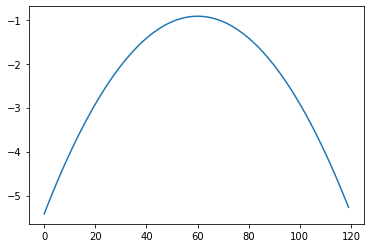

In [42]:
plt.plot(model.logpdf(xx))

In [43]:
(model.pdf(1.96), model.pdf(2.58))
(1- model.pdf(1.96), 1- model.pdf(2.58))

(0.058440944333451476, 0.014305108994149692)

(0.9415590556665485, 0.9856948910058503)

- <font color = 'red'> End

In [44]:
from scipy.stats import multivariate_normal

mu = train.drop('Class', axis=1).mean(axis=0).values
sigma = train.drop('Class', axis=1).cov().values
mu.shape
sigma.shape

model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

print(np.median(model.logpdf(valid[valid['Class'] == 0].drop('Class', axis=1).values))) 
print(np.median(model.logpdf(valid[valid['Class'] == 1].drop('Class', axis=1).values))) 

(30,)

(30, 30)

-32.81908828871442
-661.9006173762152


Once we obtain the estimates for the covariance matrix and the mean, this method is extremely fast, since it only involves computing the inverse of the sample covariance matrix, a problem that scales only with the number of dimensions in the data.

Since the probability of the data  \( P(\pmb{X} )\) is usually a very small number, we usually use the log probability as a score to avoid underflow problems. With this score, we can define a threshold above which we will classify the instances as anomalies. Now, this is equivalent to fitting a hyper-elipse to the data, centered at the mean and with eccentricity dictated by the covariance matrix; samples outside this ellipsis will be considered anomalous transactions. 

In [45]:
tresholds = np.linspace(-1000,-10, 150)
scores = []
for treshold in tresholds:
    y_hat = (model.logpdf(valid.drop('Class', axis=1).values) < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                   precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                   fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.749395648670427 110


We now plot the Precision, Recall and \(F_2 \)-score as a function of this threshold.

Text(0, 0.5, 'Score')

Text(0.5, 0, 'Threshold')

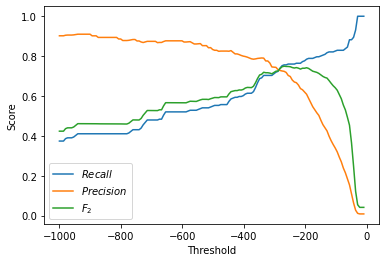

In [46]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
# plt.xticks(np.logspace(-10, -200, 3))
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Finally, we report the test recall, precision and \(F_2\)-score, along with the confusion matrix.

Final threshold: -269
Test Recall Score: 0.793
Test Precision Score: 0.701
Test F2 Score: 0.773


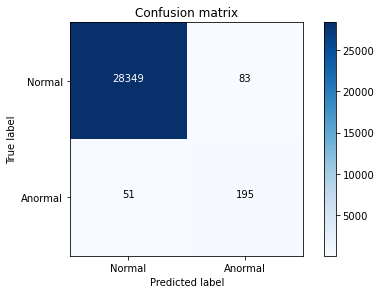

In [47]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.logpdf(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal']
                      , title='Confusion matrix')

An \(F_2\)-score of .77 is not at all bad! From the confusion matrix, we can see than only 17% of the anomalies were not detected and of the ones predicted as anomalies, only 42% were false positives. We can highlight some main advantages to this techniques. First, it is vary fast and scales well to large amounts of data; second, we don't need to tune any hyper-parameters, only the threshold; third, this technique is extremely effective even if the data is only close to Gaussian and it also captures well the relations between variables; fifth, if the distributions is robust to outliers, we can use this technique in an fully unsupervised way, without the need of labeled data; lastly, we have direct access to the probability that the data came from a normal distribution and we can also place a confidence interval around this predictions.

However, there is certainly some disadvantages in using this method. The most obvious one is that the data need not to come from a Gaussian distribution. One possibility is that the data comes from a mixture of Gaussian distribution or even by a completely different distribution. As we will see, it is actually the case that some of our features have distributions that can't be captured by this Gaussian model.

### Histogram Based

The model seen above is a parametric one in the sense the we only estimate the parameters of the multivariate distribution, namely the mean and covariance matrix. Another option is to use a non-parametric statistical technique. Here, we consider using histograms to model the normal data profile. Bellow, we see 5 histograms for different features in our data, both for normal and anomalous instances. 

In [65]:
v_features  = dataset.iloc[:,0:30].columns
v_features
len(v_features)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

30

<Figure size 1800x2304 with 0 Axes>

<AxesSubplot:xlabel='Time', ylabel='Density'>

<AxesSubplot:xlabel='Time', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: Time')

<AxesSubplot:xlabel='V1', ylabel='Density'>

<AxesSubplot:xlabel='V1', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V1')

<AxesSubplot:xlabel='V2', ylabel='Density'>

<AxesSubplot:xlabel='V2', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V2')

<AxesSubplot:xlabel='V3', ylabel='Density'>

<AxesSubplot:xlabel='V3', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V3')

<AxesSubplot:xlabel='V4', ylabel='Density'>

<AxesSubplot:xlabel='V4', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V4')

<AxesSubplot:xlabel='V5', ylabel='Density'>

<AxesSubplot:xlabel='V5', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V5')

<AxesSubplot:xlabel='V6', ylabel='Density'>

<AxesSubplot:xlabel='V6', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V6')

<AxesSubplot:xlabel='V7', ylabel='Density'>

<AxesSubplot:xlabel='V7', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V7')

<AxesSubplot:xlabel='V8', ylabel='Density'>

<AxesSubplot:xlabel='V8', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V8')

<AxesSubplot:xlabel='V9', ylabel='Density'>

<AxesSubplot:xlabel='V9', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V9')

<AxesSubplot:xlabel='V10', ylabel='Density'>

<AxesSubplot:xlabel='V10', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V10')

<AxesSubplot:xlabel='V11', ylabel='Density'>

<AxesSubplot:xlabel='V11', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V11')

<AxesSubplot:xlabel='V12', ylabel='Density'>

<AxesSubplot:xlabel='V12', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V12')

<AxesSubplot:xlabel='V13', ylabel='Density'>

<AxesSubplot:xlabel='V13', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V13')

<AxesSubplot:xlabel='V14', ylabel='Density'>

<AxesSubplot:xlabel='V14', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V14')

<AxesSubplot:xlabel='V15', ylabel='Density'>

<AxesSubplot:xlabel='V15', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V15')

<AxesSubplot:xlabel='V16', ylabel='Density'>

<AxesSubplot:xlabel='V16', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V16')

<AxesSubplot:xlabel='V17', ylabel='Density'>

<AxesSubplot:xlabel='V17', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V17')

<AxesSubplot:xlabel='V18', ylabel='Density'>

<AxesSubplot:xlabel='V18', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V18')

<AxesSubplot:xlabel='V19', ylabel='Density'>

<AxesSubplot:xlabel='V19', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V19')

<AxesSubplot:xlabel='V20', ylabel='Density'>

<AxesSubplot:xlabel='V20', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V20')

<AxesSubplot:xlabel='V21', ylabel='Density'>

<AxesSubplot:xlabel='V21', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V21')

<AxesSubplot:xlabel='V22', ylabel='Density'>

<AxesSubplot:xlabel='V22', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V22')

<AxesSubplot:xlabel='V23', ylabel='Density'>

<AxesSubplot:xlabel='V23', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V23')

<AxesSubplot:xlabel='V24', ylabel='Density'>

<AxesSubplot:xlabel='V24', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V24')

<AxesSubplot:xlabel='V25', ylabel='Density'>

<AxesSubplot:xlabel='V25', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V25')

<AxesSubplot:xlabel='V26', ylabel='Density'>

<AxesSubplot:xlabel='V26', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V26')

<AxesSubplot:xlabel='V27', ylabel='Density'>

<AxesSubplot:xlabel='V27', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V27')

<AxesSubplot:xlabel='V28', ylabel='Density'>

<AxesSubplot:xlabel='V28', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: V28')

<AxesSubplot:xlabel='Amount', ylabel='Density'>

<AxesSubplot:xlabel='Amount', ylabel='Density'>

Text(0.5, 0, '')

Text(0.5, 1.0, 'feature: Amount')

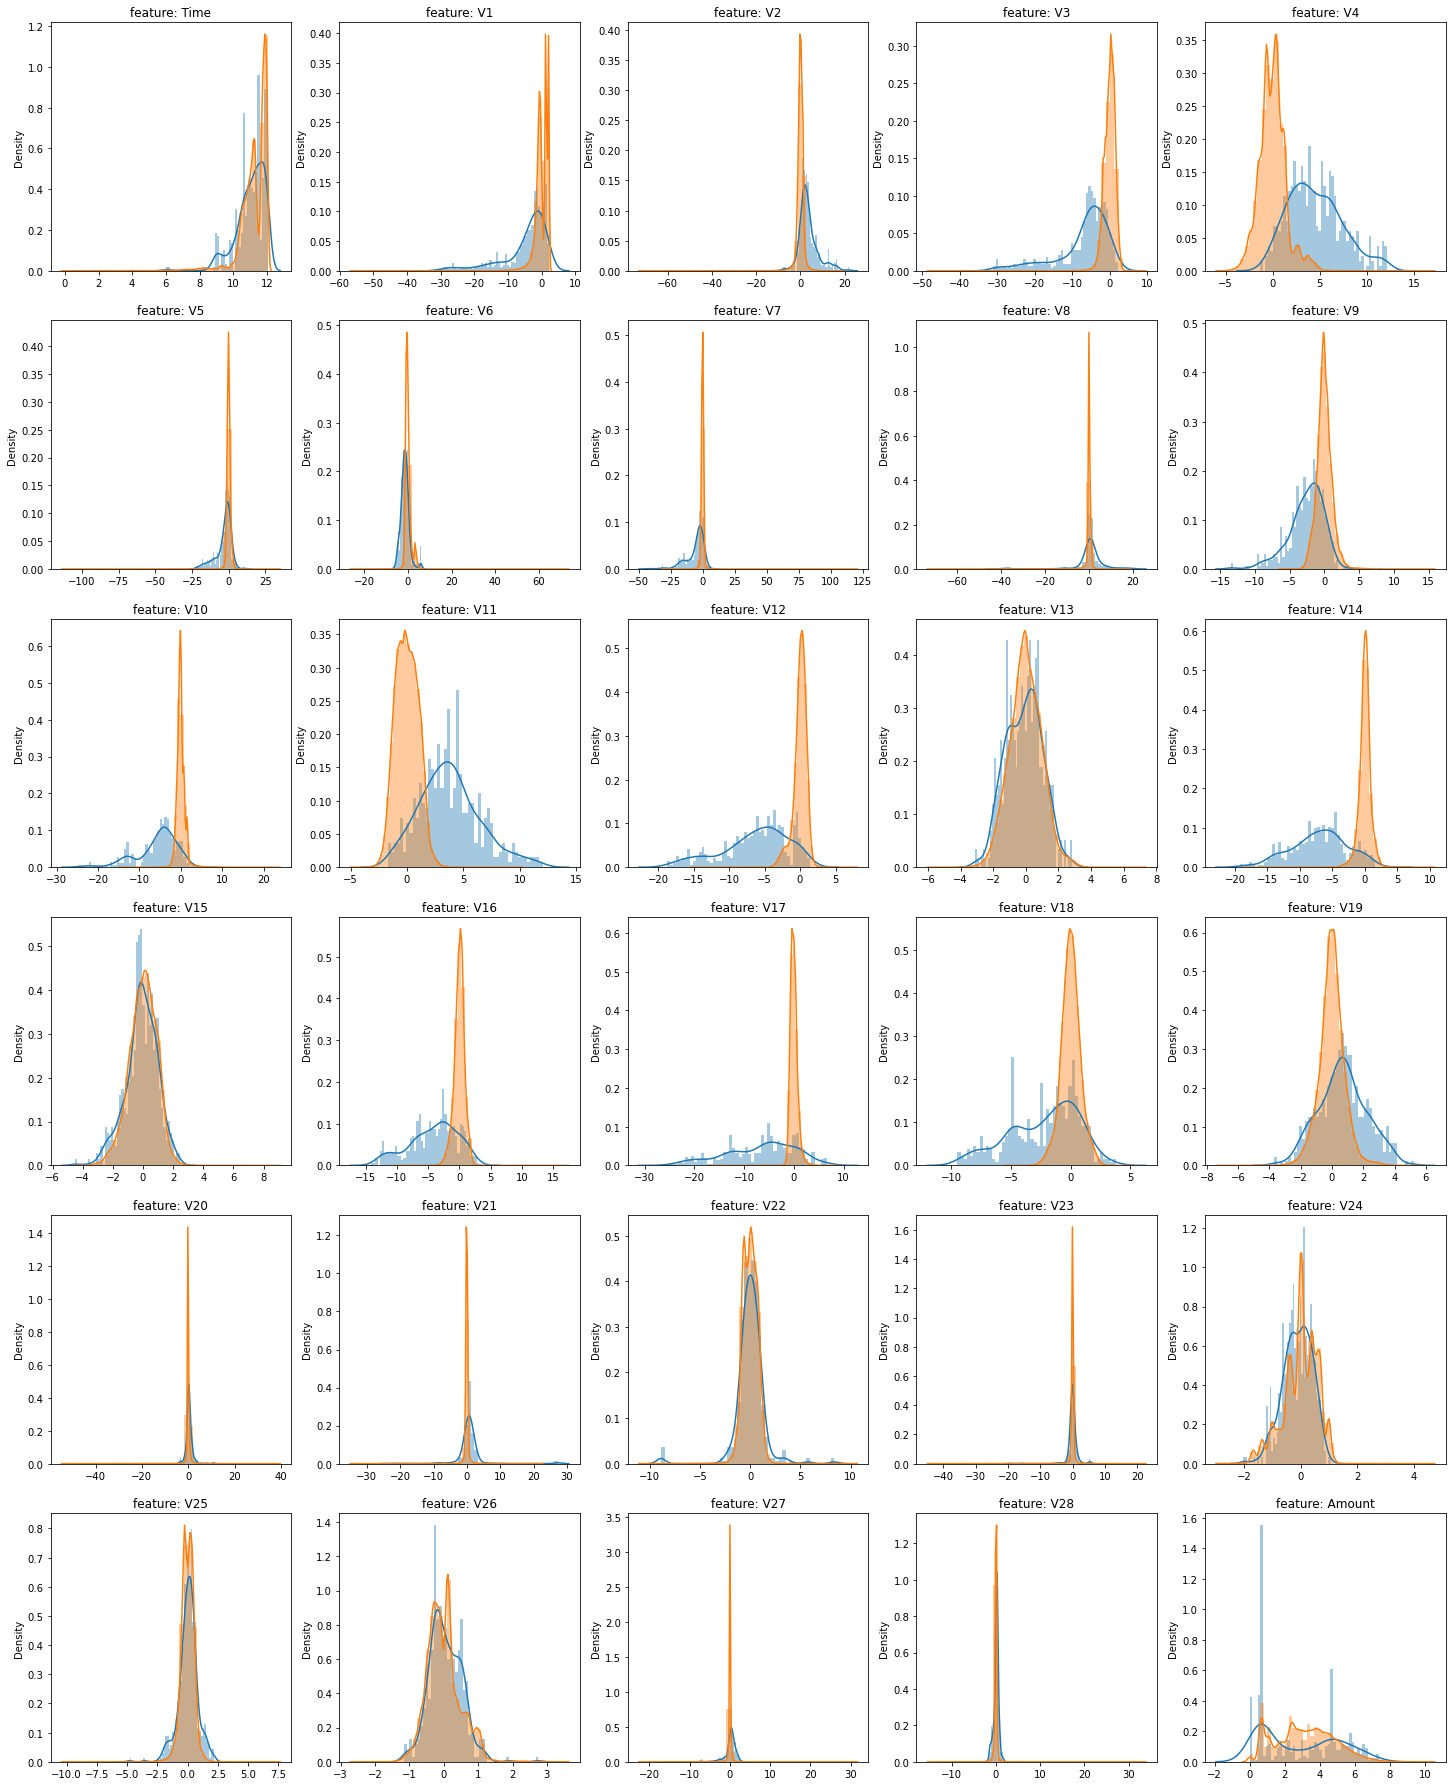

In [66]:
plt.figure(figsize=(25,8*4))
gs = gridspec.GridSpec(6, 5)
for i, cn in enumerate(dataset[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(dataset[cn][dataset.Class == 1], bins=50)
    sns.distplot(dataset[cn][dataset.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

Text(0.5, 0, '')

Text(0.5, 1.0, 'histogram of feature: Amount')

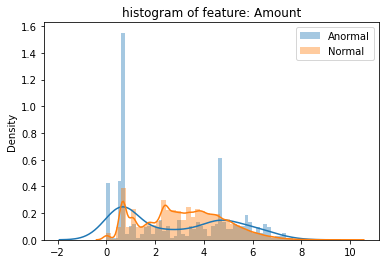

Text(0.5, 0, '')

Text(0.5, 1.0, 'histogram of feature: V4')

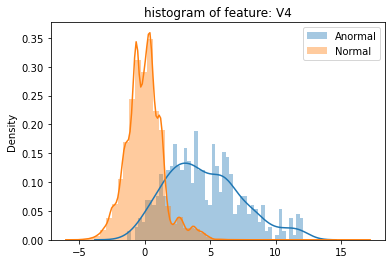

Text(0.5, 0, '')

Text(0.5, 1.0, 'histogram of feature: V10')

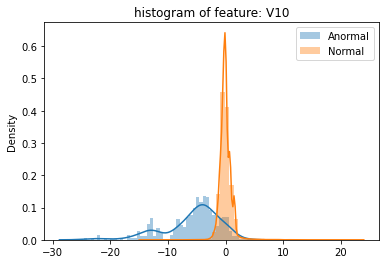

Text(0.5, 0, '')

Text(0.5, 1.0, 'histogram of feature: V11')

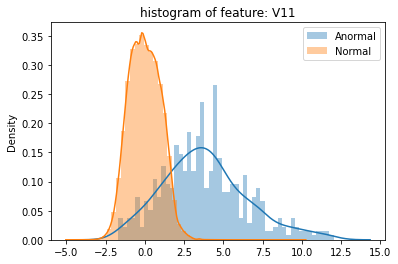

Text(0.5, 0, '')

Text(0.5, 1.0, 'histogram of feature: V15')

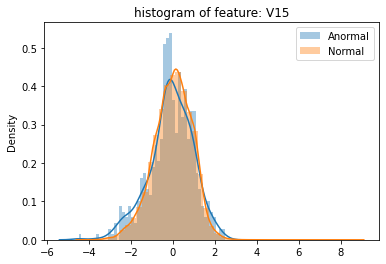

In [14]:
import matplotlib.gridspec as gridspec

# plt.figure(figsize=(12,28*5))
# gs = gridspec.GridSpec(28, 1)
for feature in ['Amount', 'V4', 'V10', 'V11', 'V15']:
    ax = plt.subplot()
    ax = sns.distplot(dataset[feature][dataset.Class == 1], bins=50, label='Anormal')
    ax = sns.distplot(dataset[feature][dataset.Class == 0], bins=50, label='Normal')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(feature))
    plt.legend(loc='best')
    plt.show()

If we think about the histogram as a way to approximate the data distribution, we can see how the normal and anomalous data can be represented by different distributions, even though they overlap in some regions. Furthermore  in the histogram for `Amount` we can see that even after we used the logarithmic transformation, it does not look very Gaussian. The distribution for normal and abnormal data have a large overlapping area, so we can't hope to use it alone to identify fraudulent transactions. The histograms for feature `V10` show better behaved distributions; for the abnormal data, we can see that is follows something close to a mixture of Gaussian, while the normal data follows a clear normal distribution. Lastly, although there is some overlap between the normal and abnormal data distribution, we can see a separating region. The histogram based techniques explore patterns like these.

The technique is actually very simple. We first model one histogram per feature in the normal training data. Than, at evaluation time, for each histogram, we see in which bin a data instance fall in. We then combine the hight of these bins to produce a final score for the data instance. If the score is tow low, it mean the data falls in bins where there is little or no normal data. We can than flag it as an anomaly.

In [15]:
class hist_model(object):
    
    def __init__(self, bins=50):
        self.bins = bins
        
    def fit(self, X):
        
        bin_hight, bin_edge = [], []
        
        for var in X.T:
            # get bins hight and interval
            bh, bedge = np.histogram(var, bins=self.bins)
            bin_hight.append(bh)
            bin_edge.append(bedge)
        
        self.bin_hight = np.array(bin_hight)
        self.bin_edge = np.array(bin_edge)
   

    def predict(self, X):
        
        scores = []
        for obs in X:
            obs_score = []
            for i, var in enumerate(obs):
                # find wich bin obs is in
                bin_num = (var > self.bin_edge[i]).argmin()-1
                obs_score.append(self.bin_hight[i, bin_num]) # find bin hitght
            
            scores.append(np.mean(obs_score))
        
        return np.array(scores)
                

        
model = hist_model()
model.fit(train.drop('Class', axis=1).values)
print(np.median(model.predict(valid[valid['Class'] == 0].drop('Class', axis=1).values))) 
print(np.median(model.predict(valid[valid['Class'] == 1].drop('Class', axis=1).values))) 

67667.86666666667
30645.86666666667


Once again, we use a validation set to determine a threshold for the score, below which we will consider the instance an anomaly. Moreover, we now have the number as bins as an hyper-parameter that we also need to tune.

In [16]:
tresholds = np.linspace(10000, 80000, 100)
scores = []
y_pred_score = model.predict(valid.drop('Class', axis=1).values)
for treshold in tresholds:
    y_hat = (y_pred_score < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)

And now we plot the recall, precision and  \( F_2 \) scores as a function of the threshold.

Text(0, 0.5, 'Score')

Text(0.5, 0, 'Threshold')

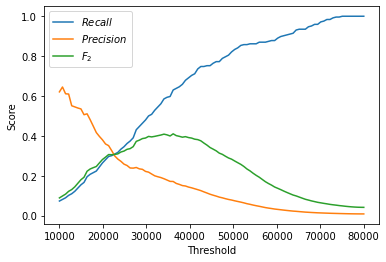

In [17]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Finaly, we pick the threshold with the best validation \(F\)-score and produce a final evaluation on the test set.

Final threshold: 36161
Test Recall Score: 0.646
Test Precision Score: 0.170
Test F2 Score: 0.415


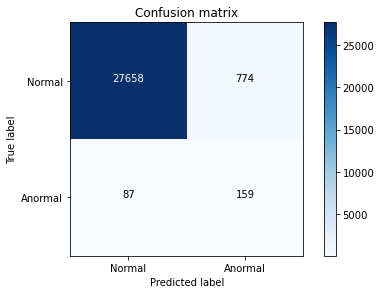

In [18]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.predict(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

We can see that the histogram based technique is much worse than the Gaussian based one. On one hand, the histogram based technique overcame the limitation of only representing a Gaussian distribution; on the other, it does not capture any relations between variables. We believe this drawback is responsible for the decrease in performance we observed here. In the case of detecting fraudulent transaction we can easily think of attribute values that are themselves frequent, but a combination of them might not be. For example, consider spending before 6:00am and spending over $1000. Each of this behaviors are frequent, but they unlikely co-occur.

## Cluster based technique

Cluster techniques are unsupervised machine learning methods used to group similar data together. Here, we explore it as a semi-supervised technique that assumes that the "*Normal data instances lie close to their closest cluster centroid, while anomalies are far away from their closest cluster centroid*". We will use an EM algorithm to cluster the data into \(n\) Gaussian. Than, at test time, we will compute the probability of the data \(P(x)\) as probability that the instance belongs to each of the fitted Gaussian.

This mixture of Gaussian model again assumes that the data comes from a mixture of Gaussian distribution. Although in theory this is sufficient to represent any distribution, provided we have the enough centroids, fitting too many clusters will cause over fitting in the sense that even anomalies will have high probability under the model distribution. Therefore, we are better of not using do many Gaussian and hence not perfectly capturing distributions like the one we saw above form the `Amount` in normal transactions. However, if the feature distributions can be well approximately by a mixture of Gaussian `(`like that one we saw in feature `V10` for the anomalous data `)`, will capture the data generating process very well. Furthermore, if we use full covariance matrix for the Gaussian, we will also account for correlations between features and overcome the limitations we noticed in the histogram based technique.

One drawback we have compared to the simple multivariate Gaussian method we used is that in the mixture of Gaussian, the number of Gaussian to fit is a hyper-parameter we also have to tune. We did this using the validation set and found 3 Gaussian to be optimal in this dataset. Another disadvantage of this technique is that it is sensitive to the starting location of the centroid and random restarts might be needed to avoid high cost local minimum.  Here, we use 4 random restarts.

In [19]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=4, random_state=42)
gmm.fit(train.drop('Class', axis=1).values)
print(gmm.score(valid[valid['Class'] == 0].drop('Class', axis=1).values))
print(gmm.score(valid[valid['Class'] == 1].drop('Class', axis=1).values))

GaussianMixture(n_components=3, n_init=4, random_state=42)

11.20112903737936
-229.49257240574633


Now, also using the validation set, we tune a threshold that will be used to classify data as normal or anomalous.

In [20]:
tresholds = np.linspace(-400, 0, 100)
y_scores = gmm.score_samples(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.7585385226370135 80


Text(0, 0.5, 'Score')

Text(0.5, 0, 'Threshold')

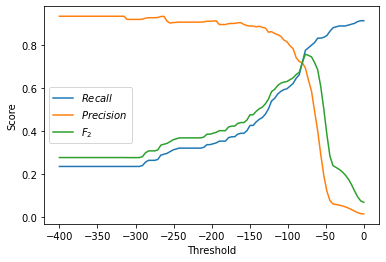

In [21]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Finally, with the trained and tuned model, we produce a final evaluation on the test set.

Final threshold: -76.767677
Test Recall Score: 0.793
Test Precision Score: 0.646
Test F2 Score: 0.758


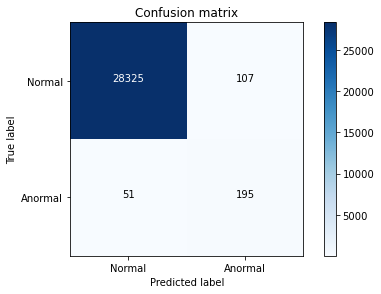

In [22]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (gmm.score_samples(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

We can see that the \(F_2\) is very good for this mixture of Gaussian model. And beyond being extremely effective, this technique is also very simple. Some disadvantages, as noted by Chandola et al, are that (1) this technique detect anomalies as a by-product of clustering and are not optimized for anomaly detection and `(`2`)` their computational complexity are often bottlenecks for large datasets.

Until now, the techniques we've considered assumed that the data came from a particular distribution or could not capture the relationship between different features in the data. We will now turn our attention to methods that have the potential to universally approximate any probability distributions. This does not mean they are better. As we will see, this extra capacity often yield worse results than the simpler methods, probably because the boundaries produced by them are too complex, causing overfitting.

## Support Vector Machines based techniques

Just like the multivariate Gaussian method, this technique finds a region that contains the normal training data. But now we are no longer limited to learning and ellipsoid shaped boundary. The support vector machine techniques fits a one class SVM to the data and uses kernels to learn arbitrarily shaped boundaries. The way this SVM works is that we first project the data onto a space with larger `(`possibly infinite`)` dimensions, where we can encapsulate the normal data in a hypersphere, even if no hypersphere could capture all data in the original space. At evaluation time, we use the distance from the boundary as a score, where negative scores means the data falls outside this boundary. As this projection operations is often to costly, we use the kernel trick to define the distance metric in the projection space without having to visit it at all.

OBS: Unfortunately, it takes too ling to run the SVM on Kaggle server, so if you want to see the result, I suggest that you download the notebook and run it locally.

In [34]:
train.sample(frac=0.1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
23743,11.832608,0.077335,0.756205,-0.123442,-0.936956,0.909080,-0.227595,0.852820,0.035400,-0.152126,...,-0.282858,-0.690799,-0.064498,-1.058742,-0.402132,0.185889,0.238838,0.075587,1.300192,0
50556,10.425876,0.960543,-0.337502,1.264405,0.723320,-0.393721,1.562817,-0.906881,0.617620,0.802771,...,0.059567,0.529597,0.187150,-0.571573,-0.086447,0.422205,0.091355,0.018178,2.771964,0
113288,11.684574,1.876507,-0.098618,-1.836773,0.587490,0.117345,-1.371654,0.369801,-0.381312,0.606179,...,0.250560,0.691661,-0.101271,-0.146881,0.208992,-0.103223,-0.017536,-0.016778,4.563827,0
211585,10.921233,-1.566015,-0.284316,0.360952,1.299826,-1.802382,0.846539,1.603248,0.478981,-0.222529,...,0.356791,0.325296,0.980740,-0.040964,0.123859,0.758430,-0.164856,0.114540,6.252790,0
200622,10.512682,1.066758,-0.987316,-0.099237,-0.307302,-1.062620,-0.994216,0.018490,-0.348547,-0.838797,...,-0.341708,-0.769533,-0.161710,0.452209,0.374353,1.072662,-0.101153,0.028882,5.212433,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212512,11.016841,-0.216810,0.911700,2.190092,1.040446,-0.231260,-0.905959,0.691278,-0.372942,-0.719510,...,-0.175171,-0.316783,-0.013571,0.934523,-0.476963,0.262602,-0.065937,-0.098372,1.091923,0
171515,10.856592,1.179568,-0.880463,0.789339,-0.622293,-1.286227,-0.324110,-0.834900,0.015089,-0.539731,...,0.201397,0.352877,-0.000619,0.084281,0.167591,-0.277157,0.032054,0.038215,4.541165,0
39176,7.981050,-0.357256,0.775124,1.118167,-2.043454,0.251137,-1.481670,1.232582,-0.492073,0.702831,...,0.070100,0.624785,-0.306974,0.409371,0.103048,-0.842059,0.244521,-0.011868,0.693147,0
96855,11.105453,-0.651942,1.220761,0.436396,-0.272575,0.229369,-0.057414,0.200421,0.620896,-0.613757,...,-0.251592,-0.873278,-0.084857,-0.927839,-0.036957,0.132569,0.106088,0.013023,2.630449,0


In [ ]:
from sklearn.svm import OneClassSVM
np.random.seed(42)

model = OneClassSVM(gamma=0.000562, nu=.95, kernel='rbf', max_iter=100)
model.fit(train.drop('Class', axis=1).values)
print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

We have to use the validation set to tune both the hyper-parameters of the one class SVM and the threshold. For the SVM, we used a radial basis kernel and tuned its hyper-parameters with a grid search.

In [18]:
tresholds = np.linspace(-50000, -400, 500)
y_scores = model.decision_function(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

In [19]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Finally, we report the results in the test set.

In [20]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.decision_function(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

This results show that the one class SVM is worse than the EM and multivariate Gaussian technique, but it is better than the histogram based one. One key disadvantage of this technique is that it extremely slow to train an SVM, being the complexity of the algorithm \( O(N^3) \). This is one major drawback that make SVM `(`with non-linear kernels`)` almost prohibitive to use in large datasets. Another disadvantage is that the SVM is often really counter intuitive to interpret, since this have to be done considering the projection space.

Some advantages include the fact the the SVM can represent any probability distribution and can be optimized to different kernels that better capture the underling data distribution.


## Tree based techniques

Tree based techniques split the data in a feature-wise fashion. Here, we will use an isolation forest that "isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature" `(`from the Sklearn documentation`)`. "In a data-induced random tree, partitioning of instances are repeated recursively until all instances are isolated. This random partitioning produces noticeable shorter paths for anomalies since `(`a`)` the fewer instances of anomalies result in a smaller number of partitions – shorter paths in a tree structure, and `(`b`)` instances with distinguishable attribute-values are more likely to be separated in early partitioning" `(`Liu and Kai, 2008`)`. We can then use the average path length for the forest as a score and flag instances with a shorter average path as anomalous transactions.

Again, this method can approximate any probability distribution. Furthermore, recursively partitioning the feature space scales logarithmically with the data size and each isolation tree can be computed in parallel, making this approach very fast. Below, we fit 50 isolation three to make our isolation forest.

In [23]:
from sklearn.ensemble import IsolationForest
np.random.seed(42)

model = IsolationForest(random_state=42, n_jobs=4, max_samples=train.shape[0], bootstrap=True, n_estimators=50)
model.fit(train.drop('Class', axis=1).values)
print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

IsolationForest(bootstrap=True, max_samples=227452, n_estimators=50, n_jobs=4,
                random_state=42)

0.1501582844248356
-0.05348996832288196


Using our validation set, we tune a threshold for our score.

In [24]:
tresholds = np.linspace(-.2, .2, 200)
y_scores = model.decision_function(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.6756756756756757 118


Text(0, 0.5, 'Score')

Text(0.5, 0, 'Threshold')

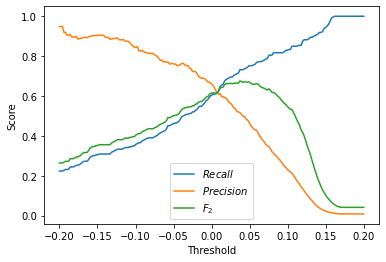

In [25]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Using the optimal threshold, we report a final test score.

Final threshold: 0.037186
Test Recall Score: 0.736
Test Precision Score: 0.523
Test F2 Score: 0.680


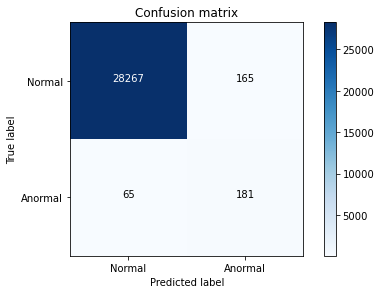

In [26]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.decision_function(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

The tree based technique is already much better than the SVM one. It also beats our benchmark, but it is worse than the EM and multivariate Gaussian.

## Neural based techniques

In recent years, unsupervised deep learning has taken the knowledge frontier in machine learning research. Many believe that by learning a good representation of the data we will be able to make our supervised models generalize better. This lead to a huge increase in unsupervised deep learning research and many algorithms are rapidly emerging. Here, we will use a well know and not so new approach of a replicating neural network named the autoencoder. In this technique, a multilayer perceptron with the same number of input and output neurons is trained with maximum likelihood to replicate the input data. To avoid simply learning the identity function, we use a bottleneck layer, with fewer neurons than the input size, thus forcing the network to compress the input in its internal representation.

If we use only normal data to train the network, we can hope it will learn a good internal representation of it and thus have a low reconstruction error wen asked to replicate normal data. Moreover, as it have never seen how the anomalous data looks like, we also hope that the network will do a poor job reconstructing the anomalies. Hence, we can use the reconstruction error, \( (\pmb{\tilde{x}} - \pmb{x})^2 \), as an anomaly score. Is the error is too large, we can then flag the instance as an anomaly.

Below, build an autoencoder with a bottleneck layer of only 2 neurons.

In [31]:
import tensorflow as tf
#tf.reset_default_graph()
tf.set_random_seed(2)

batch_size = 10000

n_visible = train.drop('Class', axis=1).values.shape[1]
n_hidden1 = 27
n_hidden2 = 16
n_hidden3 = 2

learning_rate = 0.01

# create node for input data
X_tf = tf.placeholder("float", [None, n_visible], name='X')

# Paramtetrs initialization
W1_init = 4 * np.sqrt(6. / (n_visible + n_hidden1))
W2_init = 4 * np.sqrt(6. / (n_hidden1 + n_hidden2))
W3_init = 4 * np.sqrt(6. / (n_hidden2 + n_hidden3))

W1 = tf.Variable(tf.random_uniform([n_visible, n_hidden1],
                                   minval=-W1_init, maxval=W1_init), name='W1')
b1 = tf.Variable(tf.zeros([n_hidden1]), name='b1')

W2 = tf.Variable(tf.random_uniform([n_hidden1, n_hidden2],
                                   minval=-W2_init, maxval=W2_init), name='W2')
b2 = tf.Variable(tf.zeros([n_hidden2]), name='b2')

W3 = tf.Variable(tf.random_uniform([n_hidden2, n_hidden3],
                                   minval=-W3_init, maxval=W3_init), name='W3')
b3 = tf.Variable(tf.zeros([n_hidden3]), name='b3')

W3_prime = tf.Variable(tf.random_uniform([n_hidden3, n_hidden2],
                                   minval=-W3_init, maxval=W3_init), name='W3_prime')  
b3_prime = tf.Variable(tf.zeros([n_hidden2]), name='b3_prime')

W2_prime = tf.Variable(tf.random_uniform([n_hidden2, n_hidden1],
                                   minval=-W2_init, maxval=W2_init), name='W2_prime')  
b2_prime = tf.Variable(tf.zeros([n_hidden1]), name='b2_prime')

W1_prime =  tf.Variable(tf.random_uniform([n_hidden1, n_visible],
                                   minval=-W1_init, maxval=W1_init), name='W1_prime')
b1_prime = tf.Variable(tf.zeros([n_visible]), name='b1_prime')


def autoencoder(X_tf):
    
    # encoder
    Y = tf.nn.tanh(tf.matmul(X_tf, W1) + b1)  
    Y = tf.nn.tanh(tf.matmul(Y, W2) + b2) 
    Y = tf.nn.tanh(tf.matmul(Y, W3) + b3) 
    
    # decoder
    Z = tf.nn.tanh(tf.matmul(Y, W3_prime) + b3_prime)
    Z = tf.nn.tanh(tf.matmul(Z, W2_prime) + b2_prime)  
    Z = tf.nn.tanh(tf.matmul(Z, W1_prime) + b1_prime)
    
    return Z, Y

Z, Y = autoencoder(X_tf)

cost = tf.reduce_mean(tf.pow(X_tf - Z, 2))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
scores = tf.abs(X_tf - Z)

X_train = train.drop('Class', axis=1).values
X_val_norm = valid[valid['Class'] == 0].drop('Class', axis=1).values
X_val_anorm = valid[valid['Class'] == 1].drop('Class', axis=1).values

AttributeError: module 'tensorflow' has no attribute 'set_random_seed'

We then train it with ML to reconstruct the normal data.

In [26]:
with tf.Session() as sess:
    
    tf.global_variables_initializer().run()

    for step in range(15001):
        
        offset = (step * batch_size) % (X_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :]

        sess.run(train_op, feed_dict={X_tf: batch_data,})
        
        if (step % 3000 == 0):
            print('\nBatch loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: batch_data})))
            print('Val Norm loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: X_val_norm})))
            print('Val Anorm loss at step %d: %f' % (step,sess.run(cost, feed_dict={X_tf: X_val_anorm})))
        
    y_scores_valid, enc_val = sess.run([scores, Y], feed_dict={X_tf: valid.drop('Class', axis=1).values})
    y_scores_test, enc_test = sess.run([scores, Y], feed_dict={X_tf: test.drop('Class', axis=1).values})
    


Batch loss at step 0: 5.872921
Val Norm loss at step 0: 5.909101
Val Anorm loss at step 0: 32.071228

Batch loss at step 3000: 4.506699
Val Norm loss at step 3000: 4.495435
Val Anorm loss at step 3000: 28.781940

Batch loss at step 6000: 4.476557
Val Norm loss at step 6000: 4.468804
Val Anorm loss at step 6000: 28.440264

Batch loss at step 9000: 4.443656
Val Norm loss at step 9000: 4.456771
Val Anorm loss at step 9000: 28.210590

Batch loss at step 12000: 4.410673
Val Norm loss at step 12000: 4.448496
Val Anorm loss at step 12000: 28.424364

Batch loss at step 15000: 4.378836
Val Norm loss at step 15000: 4.443304
Val Anorm loss at step 15000: 28.338223


And then we use our validation set to tune a thsershold for the score.

In [27]:
tresholds = np.linspace(0, 6, 100)

scores = []
for treshold in tresholds:
    y_hat = (y_scores_valid.mean(axis=1) > treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.581534772182 28


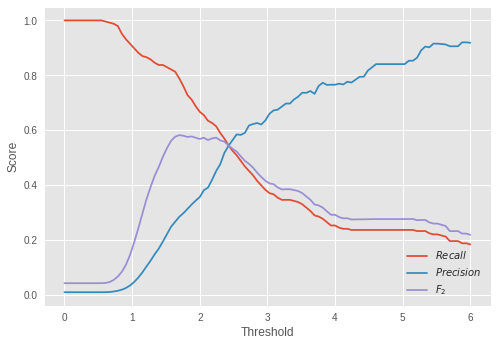

In [28]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Another interesting to do with the autoencoder is to see its internal representation of the data. Since it is trained to minimize reconstruction error, we can think of it as being similar to PCA, but non-linear. Also, since we've only used 2 neurons as our bottleneck layer, we can view their activities on a bi-plot.

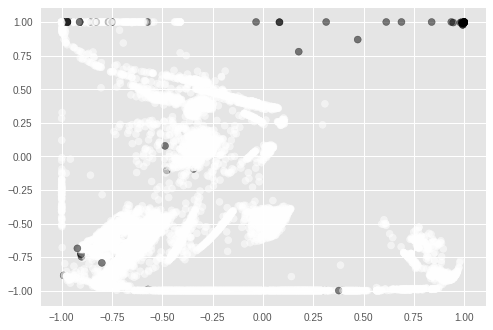

In [29]:
plt.scatter(enc_val[:, 0], enc_val[:, 1], c=valid["Class"].values, alpha=.5)
plt.show()

It is nice to see that a large amount of anomalies can be easy separated in this new feature space learned by the neural network. One could also combine this features with another technique, but we will live this for a next time.

Finally, using the test set, we can report our final results with the autoencoder.

Final threshold: 1.696970
Test Recall Score: 0.813
Test Precision Score: 0.294
Test F2 Score: 0.601


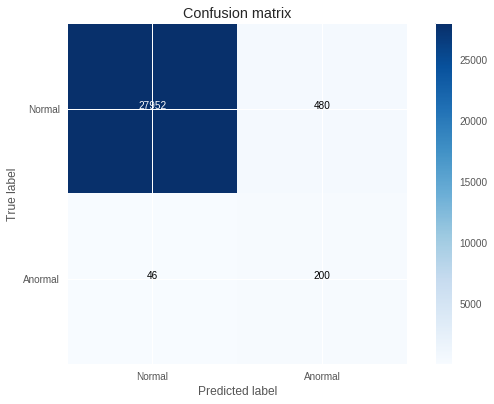

In [30]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (y_scores_test.mean(axis=1) > final_tresh).astype(int)
# print(y_hat_test.shape)
print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

We can see that the autoencoder is not that good in finding anomalies. It is only better than the SVM based technique.